In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG19

from keras.layers import Activation, Dropout, Flatten, Dense
from keras import regularizers, Sequential
from keras.layers.normalization import BatchNormalization
from keras.models import Model



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
batch_size = 64

In [ ]:
# rescale normalizes the data for the images.
# Data is split into train and validation sets
image_data_gen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True,
                                    validation_split=0.2)

train_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/TB_Chest_Radiography_Database',
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              subset='training'
                                             )

val_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/TB_Chest_Radiography_Database',
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle = False,
                                              subset='validation'
                                             )

test_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/TestImages for TB',
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              shuffle = False,
                                              class_mode='binary',
                                             )

Found 5440 images belonging to 2 classes.
Found 1360 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
dnn201 = tf.keras.applications.VGG19(
    include_top=False,
    input_tensor=None,
    input_shape=(224,224,3),
    weights = 'imagenet'
)

dnn201.trainable= False

global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
predictions = Dense(1, activation='sigmoid')

model = Sequential([
    dnn201,
    global_avg_layer,
    
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
  
    BatchNormalization(),
    Dropout(0.5),
    
    predictions
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

80142336/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________

In [ ]:
epochs = 15
history = model.fit(train_it,
                       validation_data=val_it,
                       epochs=epochs)

Epoch 1/15
85/85 [==============================] - 1825s 21s/step - loss: 0.4913 - accuracy: 0.8089 - val_loss: 0.5263 - val_accuracy: 0.8632
Epoch 2/15
85/85 [==============================] - 125s 1s/step - loss: 0.2931 - accuracy: 0.8895 - val_loss: 0.4323 - val_accuracy: 0.8287
Epoch 3/15
85/85 [==============================] - 124s 1s/step - loss: 0.2345 - accuracy: 0.9053 - val_loss: 0.3596 - val_accuracy: 0.8544
Epoch 4/15
85/85 [==============================] - 124s 1s/step - loss: 0.2030 - accuracy: 0.9227 - val_loss: 0.2741 - val_accuracy: 0.8890
Epoch 5/15
85/85 [==============================] - 124s 1s/step - loss: 0.1964 - accuracy: 0.9164 - val_loss: 0.2215 - val_accuracy: 0.9059
Epoch 6/15
85/85 [==============================] - 124s 1s/step - loss: 0.1845 - accuracy: 0.9334 - val_loss: 0.1601 - val_accuracy: 0.9449
Epoch 7/15
85/85 [==============================] - 124s 1s/step - loss: 0.1735 - accuracy: 0.9305 - val_loss: 0.1611 - val_accuracy: 0.9346
Epoch 8/15


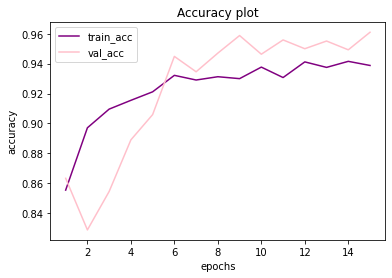

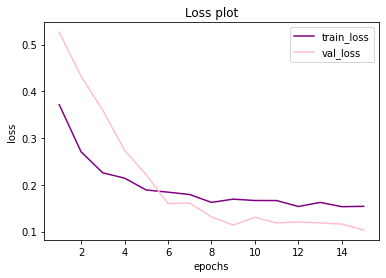

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
%matplotlib inline

epochs= range(1, len(history.history["accuracy"])+1)

plt.plot(epochs, history.history["accuracy"], color="purple")
plt.plot(epochs, history.history["val_accuracy"], color="pink")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")
plt.legend(["train_acc", "val_acc"])
plt.show()

plt.plot(epochs, history.history["loss"], color="purple")
plt.plot(epochs, history.history["val_loss"], color="pink")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [ ]:
prediction= model.predict(val_it, verbose=2)
prediction= (prediction > 0.5)
prediction

22/22 - 22s


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [False]])

In [ ]:
val_labels=val_it.classes
val_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
prediction.shape

(1360, 1)

In [ ]:
val_labels.shape

(1360,)

In [ ]:
results = model.evaluate(val_it)

22/22 [==============================] - 24s 1s/step - loss: 0.1030 - accuracy: 0.9618


0.9595588235294118
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       680
           1       0.97      0.95      0.96       680

    accuracy                           0.96      1360
   macro avg       0.96      0.96      0.96      1360
weighted avg       0.96      0.96      0.96      1360



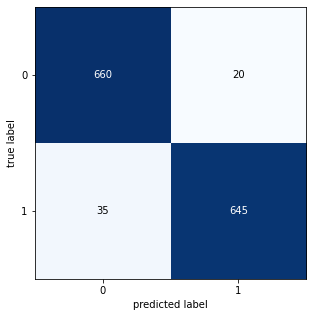

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(val_it.classes, prediction)
plot_confusion_matrix(cm, figsize=(5,5))
print(accuracy_score(val_it.classes, prediction))
print(classification_report(val_it.classes, prediction))

AUC: 0.960


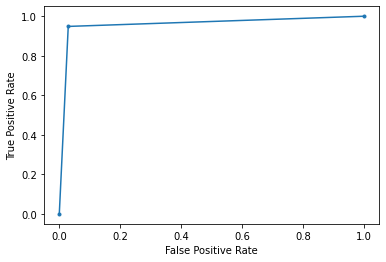

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(val_labels, prediction)
auc = metrics.roc_auc_score(val_labels, prediction)
print('AUC: %.3f' % auc)
plt.plot(fpr, tpr,marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
prediction1 = model.predict(test_it)
prediction1 = (prediction1 > 0.5)
prediction1

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [ ]:
test_labels=test_it.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [ ]:
prediction1.shape

(200, 1)

In [ ]:
test_labels.shape

(200,)

In [ ]:
results = model.evaluate(test_it)

4/4 [==============================] - 4s 733ms/step - loss: 0.0412 - accuracy: 0.9900


0.985
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       100
           1       0.98      0.99      0.99       100

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200



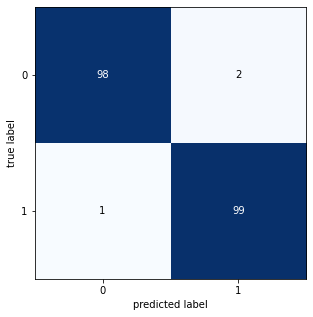

In [ ]:
cm1 = confusion_matrix(test_it.classes, prediction1)
plot_confusion_matrix(cm1, figsize=(5,5))
print(accuracy_score(test_it.classes, prediction1))
print(classification_report(test_it.classes, prediction1))

AUC: 0.985


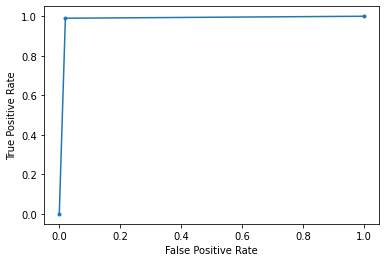

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(test_labels, prediction1)
auc = metrics.roc_auc_score(test_labels, prediction1)
print('AUC: %.3f' % auc)
plt.plot(fpr, tpr,marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/VGG19.h5')